# Generative Adversarial Network(GAN)
    
    ↪ Generator, Discriminator라는 두개의 신경망으로 구성된 딥러닝 모델.
    두 모델이 적대적으로 훈련하여 학습 데이터와 유사한 데이터 샘플을 생성

#### ▢ minimax proplem

        ✔ Generator : 생성해낸 데이터로 Discriminator를 속이도록 학습됨. (maximize D error)
                
            (1) 무작위 노이즈로부터 fake 데이터 생성 : G(z)
            (2) g_loss = adversarial_loss(discriminator(generated_imgs), real) : G(z)를 1로 인식하면 성공
                            ↪ BCEWithLogitsLoss 사용

        ✔ Discriminator : Generator가 생성한 샘플과 실제 샘플을 받아 진짜인지 가짜인지 이진 분류할 수 있도록 학습됨.(minimize D error)

            (1) 실제 이미지 : real_loss = adversarial_loss(discriminator(real_imgs), real) : real_img를 1로 인식하면 성공
            (2) 가짜 이미지 : fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake) : G(z)를 0으로 인식하면 성공
                ↪ d_loss = (real_loss + fake_loss) / 2

#### ▢ Global minimum optimization

        C(G) : the global minimum of the virtual training criterion
        C(G) = maxV(G, D) : D가 global optimum에 도달했다고 가정(Pg = Pdata, D(G(x)) = 1/2)
        C(G) = -log4 + 2*JSD(Pdata||Pg) : Pg와 Pdata의 거리가 0일때(같을 때) loss가 -log4로 최소값을 가진다.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
# latent vector를 뽑기 위한 noise 분포의 dimension
latent_dim = 100

# 일반적인 딥러닝 모델의 목표 : 데이터의 연산 결과와 실제 값의 차가 작아지도록

# 생성자의 목표 : 가짜 이미지를 생성하여 판별자가 그것을 real로 판별하도록 속이기
# 판별자의 연산 결과(0-속이기 실패 or 1-속이기 성공)와 실제 값(1)의 차(loss)를 줄이는 것
class Generator(nn.Module) :
    def __init__(self) :
        super(Generator, self).__init__()

        def block(in_dim, out_dim, normalize=True) :
            layers = nn.ModuleList()
            layers.append(nn.Linear(in_dim, out_dim))

            if normalize :
                layers.append(nn.BatchNorm1d(out_dim, 0.8))
            layers.append(nn.GELU())
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 1*28*28),
            nn.Tanh()
        )

    def forward(self, x) :  # x : [batch_size, 100] 무작위의 100차원 latent_dim을 입력받아
        img = self.model(x) # img : [batch_size, 784] 으로 출력 후
        img = img.view(img.size(0), 1, 28, 28) # img : [batch_size, 1, 28, 28]의 이미지 형태로 변경
        return img

# 판별자의 목표 : 생성자가 만든 가짜 이미지와 실제 이미지를 구별하기
# 판별자의 연산 결과(0-판별 성공 or 1-판별 실패)와 실제 값(0)의 차(loss)를 줄이는 것것
class Discriminator(nn.Module) :
    def __init__(self) :
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(1 * 28 * 28, 512),
            nn.GELU(),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Linear(256, 1),
        )

    def forward(self, img) :  # img : [batch_size, 1, 28, 28]
        flattened = img.view(img.size(0), -1) # flattened = [batch_size, 784]
        output = self.model(flattened)        # otuput = [batch_size, 1]

        return output

In [ ]:
# 학습 데이터 셋 MNIST 불러오기

transforms_train = transforms.Compose([
    transforms.Resize(28), # 이미지 크기를 28*28로 조절
    transforms.ToTensor(), # 이미지를 tensor type으로 변환
    transforms.Normalize([0.5], [0.5]) # 이미지 정규화. 픽셀 값 범위 -1 ~ 1, 평균 0.5, 표준편차 0.5
])

train_dataset = datasets.MNIST(root="./dataset", train=True, download=True, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)

100%|██████████| 9912422/9912422 [00:00<00:00, 148701894.00it/s]


Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 5821872.15it/s]


Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 130156984.97it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 16623498.05it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

adversarial_loss = nn.BCEWithLogitsLoss().to(device)
lr = 0.0005

# betas( (beta1, beta2) ) : 일차 모멘트 추정치, 이차 모멘트 추정치에 대한 지수 가중 평균 계수
# 1차는 일반적으로 0.9 근처의 값 사용, 2차는 일반적으로 0.999 근처의 값 사용
# 1차가 0.5라는건 모멘텀에 더 빠른 변화를 반영하도록 조절하는 것, GAN 학습에서는 종종 이렇게 사용됨
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=((0.5, 0.999)))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=((0.5, 0.999)))

In [ ]:
import time
import matplotlib.pyplot as plt

n_epochs = 10 # 학습의 횟수(epoch) 설정
sample_interval = 500 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정
start_time = time.time()

for epoch in range(n_epochs) :
    for i, (imgs, _) in enumerate(dataloader) :
        real = torch.FloatTensor(imgs.size(0), 1).fill_(1.0).to(device) # [batch_size, 1] : 1
        fake = torch.FloatTensor(imgs.size(0), 1).fill_(0.0).to(device) # [batch_size, 1] : 0

        real_imgs = imgs.to(device) # [batch_size, 1, 28, 28]

        # 랜덤 노이즈 샘플링
        x = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).to(device) # [batch_size, latent_dim]의 정규분포(연속확률분포)

    ### 생성자
        optimizer_G.zero_grad()

        # 생성자 이미지 생성
        generated_imgs = generator(x)

        # 생성자의 손실 값 계산 : 실제값 1, 판별 결과가 1(실제론 0 인데 1로 속이기 성공)에 근사하도록
        g_loss = adversarial_loss(discriminator(generated_imgs), real)

        # 생성자 업데이트트
        g_loss.backward()
        optimizer_G.step()

    ### 판별자
        optimizer_D.zero_grad()

        # 판별자의 손실 값 계산 1 : 실제값 1, 판별 결과가 1(실제로 1인데 1을 맞추기 성공)에 근사하도록
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        # 판별자의 손실 값 계산 2 : 실제값 0, 판별 결과가 0(실제로 0인데 0을 맞추기 성공)에 근사하도록
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # 판별자 업데이트
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(dataloader) + i # 전체 판독 수 (epoch * num_batch)

        if done % sample_interval == 0 :
            # 생성된 이미지 중에서 25개만 선택하여 5 X 5 격자 이미지에 출력
            save_image(generated_imgs.data[:25], f'{done}.png', nrow=5, normalize=True)

    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")


[Epoch 0/10] [D loss: 0.162768] [G loss: 2.692899] [Elapsed time: 44.26s]
[Epoch 1/10] [D loss: 0.444206] [G loss: 1.454063] [Elapsed time: 88.69s]
[Epoch 2/10] [D loss: 0.386167] [G loss: 1.444344] [Elapsed time: 132.92s]
[Epoch 3/10] [D loss: 0.526244] [G loss: 1.150348] [Elapsed time: 177.45s]
[Epoch 4/10] [D loss: 0.529896] [G loss: 1.258972] [Elapsed time: 222.42s]
[Epoch 5/10] [D loss: 0.420740] [G loss: 1.293919] [Elapsed time: 269.33s]
[Epoch 6/10] [D loss: 0.510658] [G loss: 1.383018] [Elapsed time: 315.28s]
[Epoch 7/10] [D loss: 0.490242] [G loss: 1.080886] [Elapsed time: 360.49s]
[Epoch 8/10] [D loss: 0.532779] [G loss: 1.128193] [Elapsed time: 405.05s]
[Epoch 9/10] [D loss: 0.637706] [G loss: 0.825498] [Elapsed time: 449.85s]


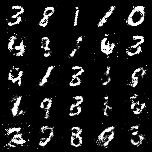

In [ ]:
from IPython.display import Image

Image('4500.png')